# Nowcasting with Pysteps

This is a little example about how to use [Pysteps library](https://pysteps.readthedocs.io/en/latest/index.html) for nowcasting precipitation. It complements the examples proposed on his documentation.

Import libraries

In [1]:
import numpy as np
from pprint import pprint
from pysteps import motion, nowcasts, verification
from pysteps.utils import conversion, transformation
import matplotlib.pyplot as plt

Pysteps configuration file found at: C:\Users\Elmer Lopez Ramirez\Anaconda3\envs\radar\lib\site-packages\pysteps\pystepsrc



Read the file. In this case, data has archived using  ".h5py" extension. It could be open using **`h5py`** library. 

In [2]:
import h5py

In [3]:
f = h5py.File("./data/14052019.hdf5", "r")
a_group_key = list(f.keys())[0]
data = f[a_group_key]
data = np.array(data).astype('float')
f.close()

Data corresponds a PPI scan of X-band radar of Peru. It contains reflectivity values(dBZ) of a drizzly of 14/05/2019. 

In [4]:
data.shape

(15, 2000, 2000)

How you can see, temporal axis corresponds axis 0. This is the standart in Pysteps and Rainymotion.

We see the data. 

In [5]:
from matplotlib import animation
from IPython.display import HTML

ims = []
fig = plt.figure(figsize=(6,6))

for i in range(data.shape[0]):
    im = plt.imshow(data[i, ...], vmax=40, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
plt.close(ani._fig)
HTML(ani.to_html5_video())

For this example, we select the seventh for the nowcasting. 

In [6]:
metadata = {'institution':'UdeP', 'unit':'dBZ', 'transform':'dB',
            'accutime': 5.0, 'threshold':-31.5, 'zerovalue': -31.5}
n_leadtimes = 8

Pysteps works with a scheme that use metadata for transformation and plotting. For further details see [the reference](https://pysteps.readthedocs.io/en/latest/pysteps_reference/io.html#pysteps-io-importers). Variable **`n_leadtimes`** represents number of time steps. 

Converts data from dbz to rain rate. By default Pysteps use Marshall-Palmer relation (a=200, b=1.6)

In [7]:
R, metadata = conversion.to_rainrate(data, metadata)
R_mini = R[0:7, ...]     # Select the seventh for nowcasting. The rest of data it's for comparison.  
pprint(metadata)

{'accutime': 5.0,
 'institution': 'UdeP',
 'threshold': 0.0003918377307968165,
 'transform': None,
 'unit': 'mm/h',
 'zerovalue': 0.0,
 'zr_a': 200.0,
 'zr_b': 1.6}


Transform to dBR. This is because rainfall rate follow an asimmetry distribution. For Optical Flow methods its better to have a Gaussian distribution. Pysteps provides another transformations like Square Root, Box-Cox and Normal Quartile Transform.

In [8]:
dR, metadata = transformation.dB_transform(R_mini, metadata, threshold=0.1, zerovalue=-15.0)
pprint(metadata)

{'accutime': 5.0,
 'institution': 'UdeP',
 'threshold': -10.0,
 'transform': 'dB',
 'unit': 'mm/h',
 'zerovalue': -15.0,
 'zr_a': 200.0,
 'zr_b': 1.6}


Calculate velocity using a optical flow method. Several methods are implemented how Lucas-Kanade(LK), Variational Echo Tracking(VET), DARTS and Proesmans. In this example, we use Lucas-Kanade method that is a local - method. Only give the last three data for calculating velocity.

In [9]:
oflow_method = motion.get_method("LK")
V = oflow_method(dR[-3:, :, :])

Extrapolate data. 

In [10]:
extrapolate = nowcasts.get_method("extrapolation")
dR[~np.isfinite(dR)] = metadata["zerovalue"]     # Deal with Inf and NaN
R_f = extrapolate(dR[-1, :, :], V, n_leadtimes)

Back-transform to rain rate

In [11]:
R_f, metadata = transformation.dB_transform(R_f, metadata,threshold=-10.0, inverse=True)
R_f[:, np.isnan(R[-1, ...])] = np.nan  # Put NaN values on extrapolated data

Results can't plotting using visualization functions of Pysteps without add projection metadata. For this reason, just simply plotting using **`plt.imshow()`**


In [12]:
fig = plt.figure(figsize=(6,6))
ims = []

# Data
for i in range(R.shape[0]):
    im = plt.imshow(R[i, ...], vmax=2, animated=True)      # Original data
    ims.append([im])

# Nowcasting
for i in range(n_leadtimes):
    im = plt.imshow(R_f[i, ...], vmax=2, animated=True)    # Nowcasting 
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
plt.close(ani._fig)
HTML(ani.to_html5_video())

If we wants, we can return to the original units using data transformations options. 

In [13]:
metadata['unit'] = 'mm/h'
nowcast, metadata = conversion.to_reflectivity(R_f, metadata)
nowcast[nowcast == np.nanmin(nowcast)] = -31.5

Pysteps offers statistics for comparison on his module **`pysteps.verification`**. 

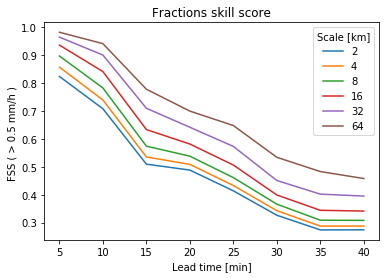

In [15]:
fss = verification.get_method("FSS")
timestep = 5     # Time interval in minutes
scales = [2, 4, 8, 16, 32, 64]     # Scale for comparison
thr = 0.2      # Threshold for the method
score = []
for i in range(n_leadtimes):
    score_ = []
    for scale in scales:
        score_.append(fss(R_f[i, :, :], R[7 + i, :, :], thr, scale))
    score.append(score_)

plt.figure()
x = np.arange(1, n_leadtimes + 1) * timestep
plt.plot(x, score)
plt.legend(scales, title="Scale [km]")
plt.xlabel("Lead time [min]")
plt.ylabel("FSS ( > 0.5 mm/h ) ")
plt.title("Fractions skill score")
plt.show()

Results are a bit disappointing. But if you see the video, in this example, precipitation doesn't decorrelated easily with time because his lifetime is very short. Methods like this works better with a precipitation that has lifetimes longer. 